In [1]:
using FundamentalsNumericalComputation

┌ Info: verify download of index files...
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\MatrixDepot.jl:117


┌ Info: reading database
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:24
┌ Info: adding metadata...
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:68


┌ Info: adding svd data...
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:70


┌ Info: writing database
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:75
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\MatrixDepot.jl:119


# Chapter 5: Interpolation

This chapter covered interpolation (linear, cubic) as well as numerical integration (trapezoidal, Simpson's rule).  The final section discussed adaptive integration, using divide and conquer to improve the accuracy of the result. 

I don't plan to summarize this chapter further, except to point out two observations:

* Simpsons rule is the minimal that should be used in practice.  For the divide and conquer they used the next order up from Simpsons (accurate to 4th order). 

* Approximating derivatives using finite differences leads to stability issues due to subtractive cancellation. It turns out that although the error decreases as you decrease $\delta x$, the stability also decreases, and there is an optimal value of $\delta x \approx \sqrt{\epsilon_{\text{mach}}}$ that minimizes the total error (for forward differences).

Adaptive integration example code:

In [48]:
"""
    intadapt(f,a,b,tol)

Adaptively integrate `f` over [`a`,`b`] to within target error 
tolerance `tol`. Returns the estimate and a vector of evaluation 
nodes.
"""
function intadapt(f,a,b,tol,fa=f(a),fb=f(b),m=(a+b)/2,fm=f(m))
    # Use error estimation and recursive bisection.
    # These are the two new nodes and their f-values.
    xl = (a+m)/2;  fl = f(xl);
    xr = (m+b)/2;  fr = f(xr);
    
    # Compute the trapezoid values iteratively.
    h = (b-a)
    T = [0.,0.,0.]
    T[1] = h*(fa+fb)/2
    T[2] = T[1]/2 + (h/2)*fm
    T[3] = T[2]/2 + (h/4)*(fl+fr)
    
    S = (4T[2:3]-T[1:2]) / 3      # Simpson values
    E = (S[2]-S[1]) / 15           # error estimate
    
    if abs(E) < tol*(1+abs(S[2]))  # acceptable error?
        Q = S[2]                   # yes--done
        nodes = [a,xl,m,xr,b]      # all nodes at this level
    else
        # Error is too large--bisect and recurse.
        QL,tL = intadapt(f,a,m,tol,fa,fm,xl,fl)
        QR,tR = intadapt(f,m,b,tol,fm,fb,xr,fr)
        Q = QL + QR
        nodes = [tL;tR[2:end]]   # merge the nodes w/o duplicate
    end
    return Q,nodes
end

intadapt

## Exercise 5.1.2

The following table gives the life expectancy in the U.S. by year of birth.

    | 1980 | 1985 | 1990 | 1995 | 2000 | 2005 | 2010 |
    |:---:|:----:|:-----:|:----:|:----:|:----:|:----:|
    | 73.7 | 74.7 | 75.4 | 75.8 | 77.0 | 77.8 | 78.7 |

**(a)** Defining "year since 1980" as the independent variable, use `fit` to construct and plot the polynomial interpolant of the data.

**(b)** Use `Spline1D` to construct and plot a piecewise cubic interpolant of the data.

**(c)** Use both methods to estimate the life expectancy for a person born in 2007. Which value is more believable?

In [40]:
x= [1980., 1985., 1990., 1995., 2000., 2005., 2010.] .- 1980.0
y = [73.7, 74.7, 75.4, 75.8, 77.0, 77.8, 78.7]


7-element Vector{Float64}:
 73.7
 74.7
 75.4
 75.8
 77.0
 77.8
 78.7

In [41]:
x[end]

30.0

In [32]:
n=length(x)

7

a)

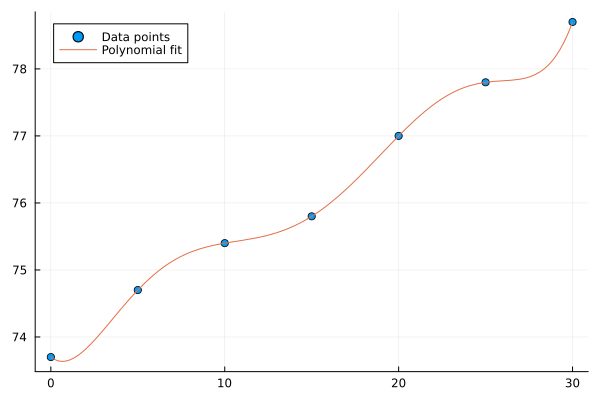

In [42]:
p = Polynomials.fit(x,y,n-1)
scatter(x,y,label="Data points")
plot!(x->p.(x),x[1],x[end],label="Polynomial fit")

b)

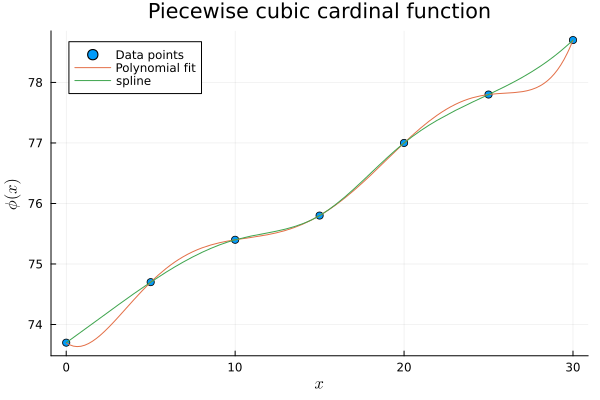

In [43]:
s =  Spline1D(x,y)
plot!(x->s(x),x[1],x[end],label="spline",
    xlabel=L"x",ylabel=L"\phi(x)",
    title="Piecewise cubic cardinal function")

c)

In [44]:
s(2007.0-1980.0)

78.08420000000004

In [45]:
p(2007.0-1980.0)

77.84749952000016

The spline is more believable, as the polynomial takes a dip here which is not motivated by the data.

## Exercise 5.8.1 e)
For each integral below, use `intadapt` with error tolerance $10^{-2},10^{-3},\ldots,10^{-12}$. Make a table of errors and the number of integrand evaluation nodes used, and use a convergence plot as in demo in the text to compare to fourth-order accuracy.  

**(e)** $\displaystyle \int_0^1 \sqrt{1-x^2}\, dx = \frac{\pi}{4}$



In [60]:
function f(x)
    sqrt(1-x^2)
end

Q = pi/4

tol = [ 1/10^k for k in 2:12 ]
err,n = [],[]
for tol in tol
    A,t = FNC.intadapt(f,0,1,tol)
    push!(err,Q-A)
    push!(n,length(t))
end

In [61]:

pretty_table([tol err n],["tolerance","error","number of nodes"]) 

┌───────────┬─────────────┬─────────────────┐
│ tolerance │       error │ number of nodes │
├───────────┼─────────────┼─────────────────┤
│      0.01 │   0.0144994 │               5 │
│     0.001 │  0.00510087 │               9 │
│    0.0001 │ 0.000640117 │              17 │
│    1.0e-5 │  8.49393e-5 │              25 │
│    1.0e-6 │  5.53976e-6 │              41 │
│    1.0e-7 │  7.11173e-7 │              65 │
│    1.0e-8 │  1.06141e-7 │              97 │
│    1.0e-9 │  1.52192e-8 │             153 │
│   1.0e-10 │  1.75218e-9 │             245 │
│   1.0e-11 │ 2.44446e-10 │             389 │
│   1.0e-12 │ 3.70806e-11 │             617 │
└───────────┴─────────────┴─────────────────┘


This is one way to estimate $\pi$.

In [63]:
A, t = intadapt(f,0,1,1e-12)
A*4.0 - pi

-1.4832224337624211e-10

In [65]:
length(t)

617

An alternative that uses much less evaluations:

$$
\int_{0}^{1} \frac{1}{1+x^2} dx = \pi/4
$$


 

In [69]:
function estimate_pi(precision::Float64)
    f(x) = 1 / (1 + x^2)
    A, t = intadapt(f, 0, 1, precision)
    return 4*A , length(t)
end

pi_est, n = estimate_pi(1e-12)

(3.1415926535891647, 253)

In [70]:
pi_est - pi

-6.283862319378386e-13